<a href="https://colab.research.google.com/github/MoronSlayer/Deep-Learning-Projects/blob/learner/TripletMarginLoss_MNIST_kaggle_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
# !wget https://www.kaggle.com/competitions/digit-recognizer/data?select=test.csv

In [3]:
PATH = "/content/kaggle/"

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [4]:
embedding_dims = 50
batch_size = 32
epochs = 5

In [18]:
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
la

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [70]:
a = train_df.drop['label']

TypeError: ignored

In [69]:
a

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img
        

In [21]:
from sklearn.model_selection import train_test_split
train_loader, test_loader = train_test_split(train_df, test_size=0.2)

In [9]:
train_loader

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
37720,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24131,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32734,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37942,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32387,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1661,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18523,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40259,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
train_ds = MNIST(train_df, 
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [23]:
test_ds = MNIST(test_loader, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [12]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [13]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

In [14]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [15]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

In [37]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
from torchviz import make_dot
``
make_dot(anchor_out, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [17]:
list(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ValueError: ignored

In [24]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 1/5 - Loss: 0.1199


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 2/5 - Loss: 0.0472


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 3/5 - Loss: 0.0383


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 4/5 - Loss: 0.0338


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 5/5 - Loss: 0.0295


In [29]:
anchor_label.shape

torch.Size([16])

In [24]:
torch.save({"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }, "trained_model.pth")

In [32]:
anchor_list = []
positive_list = []
negative_list = []
for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
    anchor_img = anchor_img.to(device)
    positive_img = positive_img.to(device)
    negative_img = negative_img.to(device)
    anchor_out = model(anchor_img)
    positive_out = model(positive_img)
    negative_out = model(negative_img)
    for i in range(len(anchor_out)):
      anchor_list.append(anchor_out[i].tolist())
      positive_list.append(positive_out[i].tolist())
      negative_list.append(negative_out[i].tolist())


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [35]:
anchor_list = np.array(anchor_list)
positive_list = np.array(positive_list)
negative_list = np.array(negative_list)

In [39]:
from numpy.linalg import norm

In [42]:
sum = 0
for i in range(len(anchor_list)):
  sum+=np.dot(anchor_list[i],positive_list[i])/(norm(anchor_list[i])*norm(positive_list[i]))

sum=sum/len(anchor_list)
sum

0.8719943765043086

In [43]:
sum = 0
for i in range(len(anchor_list)):
  sum+=np.dot(anchor_list[i],negative_list[i])/(norm(anchor_list[i])*norm(negative_list[i]))

sum=sum/len(anchor_list)
sum

0.0017391616703177886

In [49]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(test_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/875 [00:00<?, ?it/s]

ValueError: ignored

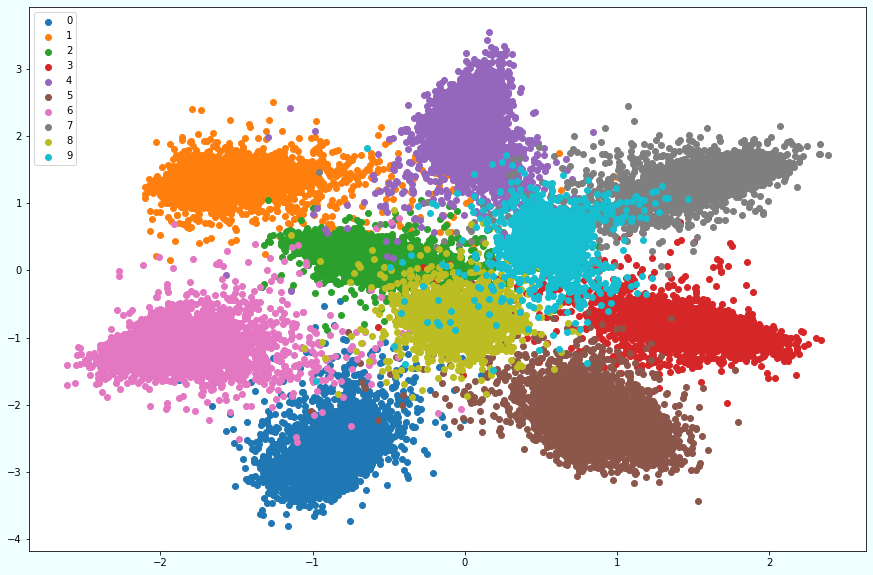

In [41]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

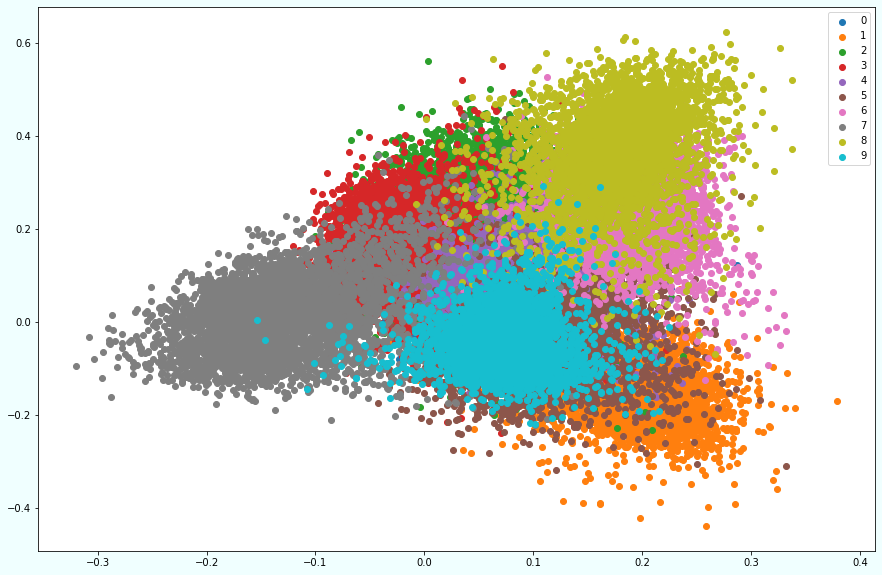

In [43]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()